In [5]:
# Example code for reading the data and the initial weights and biases.
# Note: This is just an example of how to read these files, you can modify the code in your own implementation.

import numpy as np
import math
import matplotlib.pyplot as plt
import copy

train_x, train_y = np.load('DL_HW1/fashion_mnist/train_x.npy'), np.load('DL_HW1/fashion_mnist/train_y.npy')
test_x, test_y = np.load('DL_HW1/fashion_mnist/test_x.npy'), np.load('DL_HW1/fashion_mnist/test_y.npy')

# normalized
train_x = train_x/255
test_x = test_x/255

print('shape of data:')
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)
print()

checkpoint = np.load('DL_HW1/weights.npy', allow_pickle=True).item()
init_weights = checkpoint['w']
init_biases = checkpoint['b']

print('shape of weights:')
for w in init_weights:
    print(w.shape)

print('shape of biases:')
for b in init_biases:
    print(b.shape)

shape of data:
(30000, 784)
(30000,)
(5000, 784)
(5000,)

shape of weights:
(784, 2048)
(2048, 512)
(512, 5)
shape of biases:
(2048,)
(512,)
(5,)


# 1. FNN

In [6]:
class FNN():
  def __init__(self,train_x,train_y,test_x,test_y,init_weights,init_biases,Zero=False,dropout=False):
    self.train_x = copy.deepcopy(train_x)
    self.train_y = copy.deepcopy(train_y)
    self.test_x = copy.deepcopy(test_x)
    self.test_y = copy.deepcopy(test_y)
    self.layer = [2048,512,5]
    self.batchSize = 200
    self.learningRate = 0.001
    self.num_epochs = 20
    self.dropout = dropout
    self.finalWeights = []
    self.finalBiases = []

    if(Zero):
      # for zero initialization
      w = []
      b = []
      w.append(np.zeros([784,2048]))
      w.append(np.zeros([2048,512]))
      w.append(np.zeros([512,5]))
      b.append(np.zeros(2048).flatten())
      b.append(np.zeros(512).flatten())
      b.append(np.zeros(5).flatten())
      self.weights = w
      self.biases = b
      
    else:
      self.weights = copy.deepcopy(init_weights)
      self.biases = copy.deepcopy(init_biases)

  def ReLU(self,X):
    return np.maximum(0,X)

  def softmax(self,X):
    X = X-np.max(X,axis=1,keepdims=True)
    X = np.exp(X)
    X = X/np.sum(X,axis=1,keepdims=True)
    return X

  def forward(self,X,weights,biases,training,dropout):
    z_data = []
    act_data = []
    w = weights.copy()
    b = biases.copy()

    # for dropout
    if(training == False and dropout == True):
      for i in range(len(w)):
        w[i] = w[i] * 0.8

    z_data.append(np.dot(X, w[0])+b[0])
    act_data.append(self.ReLU(z_data[0]))  
    # for dropout
    #if (training and dropout):
    #  mask = np.random.rand(act_data[0].shape[0],act_data[0].shape[1])<0.8
    #  act_data[0] *= mask

    z_data.append(np.dot(act_data[0],w[1])+b[1])
    act_data.append(self.ReLU(z_data[1]))
    # for dropout
    if (training and dropout):
      mask = np.random.rand(act_data[1].shape[0],act_data[1].shape[1])<0.8
      act_data[1] *= mask

    z_data.append(np.dot(act_data[1], w[2])+ b[2])
    act_data.append(self.softmax(z_data[2]))

    return z_data,act_data

  def backward_ReLU(self,X):
    # the derivate of ReLU
    X[X <= 0] = 0
    return X

  def backward_softmax(self,predict,true):
    dz = predict.copy()
    dz[range(len(predict)), true] -= 1 # A[-1] - y
    return dz / len(predict)

  def backward(self,Z,A,w,b,x,y):
    dz = []
    dw_data = []
    db_data = []

    dz = self.backward_softmax(A[-1], y)
    dw_data.insert(0,np.dot(A[1].T,dz) * 1/x.shape[1])
    db_data.insert(0,np.sum(dz,axis=0) * 1/x.shape[1])

    dz = np.multiply(np.dot(dz,w[2].T) , self.backward_ReLU(A[1]))
    dw_data.insert(0,np.dot(A[0].T,dz) * 1/x.shape[1])
    db_data.insert(0,np.sum(dz,axis=0) * 1/x.shape[1])

    dz = np.multiply(np.dot(dz,w[1].T) , self.backward_ReLU(A[0]))
    dw_data.insert(0,np.dot(x.T,dz) * 1/x.shape[1])
    db_data.insert(0,np.sum(dz,axis=0) * 1/x.shape[1])

    for i in range(len(w)):
      w[i] -= self.learningRate * dw_data[i]
      b[i] -= self.learningRate * db_data[i]

    return w,b

  def cross_entropy(self,predict,target):
    target = np.eye(5)[target]
    return -np.sum(np.multiply(target , np.log(np.clip(predict,1e-7,1-1e-7))))/ len(target)

  def cal_accuracy(self,act_values,label):
    y_predict = np.argmax(act_values[-1],axis=1)
    return np.mean(y_predict==label)
  
  def train(self):
    train_accuracyList = []
    train_lossList = []
    test_accuracyList = []
    test_lossList = []
    weights = self.weights.copy()
    biases = self.biases.copy()

    # mini-batch SGD
    mini_batch = math.ceil(self.train_x.shape[0]/self.batchSize)
    for epoch in range(self.num_epochs):
      for i in range(mini_batch):
        train = self.train_x[i*self.batchSize:(i+1)*self.batchSize]
        label = self.train_y[i*self.batchSize : (i+1)*self.batchSize]

        # forward pass
        z = []
        A = []
        Z,A = self.forward(train,weights,biases,True,self.dropout) # A[-1] is prediction
        # backward pass and update
        weights,biases = self.backward(Z,A,weights,biases,train,label)

        if((self.batchSize*epoch+i+1)%50==0):
          train_z_data, train_act_values = self.forward(self.train_x,weights,biases,False,self.dropout)
          train_accu = self.cal_accuracy(train_act_values,self.train_y)
          train_loss = self.cross_entropy(train_act_values[-1],self.train_y)
          
          test_z_data, test_act_values = self.forward(self.test_x,weights,biases,False,self.dropout)
          test_accu = self.cal_accuracy(test_act_values,self.test_y)
          test_loss = self.cross_entropy(test_act_values[-1],self.test_y)

          train_accuracyList.append(train_accu)
          train_lossList.append(train_loss)
          
          test_accuracyList.append(test_accu)
          test_lossList.append(test_loss)
          print('Train iteration: {}/{} Traing_Loss: {} Traing_acc: {:.6f} Test_Loss: {} Test_accuracy: {:.6f}'.format(mini_batch*epoch+i, self.num_epochs*mini_batch , train_loss, train_accu, test_loss, test_accu))

    self.finalWeights = weights
    self.finalBiases = biases

    print("【Training】")
    print("Accuracy : ",train_accuracyList[-1])
    print("Loss : ",train_lossList[-1])
    print("【Testing】")
    print("Accuracy : ",test_accuracyList[-1])
    print("Loss : ",test_lossList[-1])

    # visualization
    plt.figure(figsize = (12, 5), dpi = 72)
    plt.subplot(1,2,1)
    plt.title('Accuracy')
    plt.xlabel('Iterations')
    plt.ylabel('Acc')
    plt.plot(test_accuracyList,label='Testing',color='r')
    plt.plot(train_accuracyList,label='Training',color='b')
    plt.legend()
    plt.subplot(1,2,2)
    plt.title('Learning Curve')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.plot(test_lossList,label='Testing',color='r')
    plt.plot(train_lossList,label='Training',color='b')
    plt.legend()
    plt.show()

## 1.(a)

Train iteration: 49/3000 Traing_Loss: 1.0413957565055703 Traing_acc: 0.935000 Test_Loss: 1.1111435427475989 Test_accuracy: 0.930800
Train iteration: 99/3000 Traing_Loss: 0.8320132708070511 Traing_acc: 0.948067 Test_Loss: 0.8980170537794038 Test_accuracy: 0.944000
Train iteration: 149/3000 Traing_Loss: 0.6544599915683629 Traing_acc: 0.959200 Test_Loss: 0.7280998462054656 Test_accuracy: 0.954600
Train iteration: 199/3000 Traing_Loss: 0.6146990274408286 Traing_acc: 0.961633 Test_Loss: 0.699543390885021 Test_accuracy: 0.956600
Train iteration: 249/3000 Traing_Loss: 0.6388651521021693 Traing_acc: 0.960133 Test_Loss: 0.751006749154356 Test_accuracy: 0.953200
Train iteration: 299/3000 Traing_Loss: 0.5513195870570582 Traing_acc: 0.965500 Test_Loss: 0.6486406215725162 Test_accuracy: 0.959400
Train iteration: 349/3000 Traing_Loss: 0.49223720632315193 Traing_acc: 0.969133 Test_Loss: 0.6304931397092411 Test_accuracy: 0.960800
Train iteration: 399/3000 Traing_Loss: 0.5072236514384728 Traing_acc: 0.

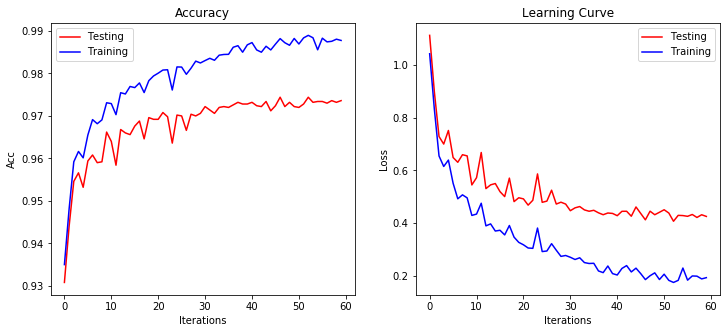

In [7]:
model = FNN(train_x,train_y,test_x,test_y,init_weights,init_biases)
model.train()

## 1.(b) considering zero initialization for the model weights.
把weights全部初始化為零導致模型經過每層後歸零，再之後導致無法有效更新參數進行訓練，所以Accuracy趨近平行線，，由此可知初始化參數也是導致模型快速收斂的關鍵因素。(圖中只看到藍線是因為結果太相近跟紅線重疊了)

Train iteration: 49/3000 Traing_Loss: 1.6094379124341391 Traing_acc: 0.200000 Test_Loss: 1.6094379124341394 Test_accuracy: 0.200000
Train iteration: 99/3000 Traing_Loss: 1.6094379124341052 Traing_acc: 0.200000 Test_Loss: 1.609437912434105 Test_accuracy: 0.200000
Train iteration: 149/3000 Traing_Loss: 1.6094379124341 Traing_acc: 0.200000 Test_Loss: 1.6094379124341003 Test_accuracy: 0.200000
Train iteration: 199/3000 Traing_Loss: 1.60943791243414 Traing_acc: 0.200000 Test_Loss: 1.6094379124341394 Test_accuracy: 0.200000
Train iteration: 249/3000 Traing_Loss: 1.6094379124341054 Traing_acc: 0.200000 Test_Loss: 1.6094379124341052 Test_accuracy: 0.200000
Train iteration: 299/3000 Traing_Loss: 1.6094379124341003 Traing_acc: 0.200000 Test_Loss: 1.6094379124341003 Test_accuracy: 0.200000
Train iteration: 349/3000 Traing_Loss: 1.6094379124341391 Traing_acc: 0.200000 Test_Loss: 1.6094379124341398 Test_accuracy: 0.200000
Train iteration: 399/3000 Traing_Loss: 1.609437912434105 Traing_acc: 0.200000

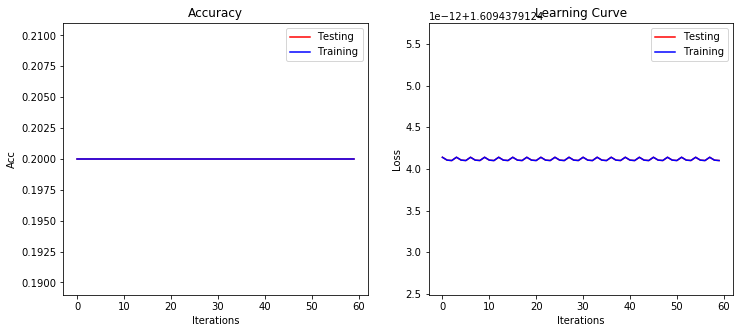

In [4]:
zero_model = FNN(train_x,train_y,test_x,test_y,init_weights,init_biases,Zero=True)
zero_model.train()

## 2.(a) implement the dropout layers

Train iteration: 49/3000 Traing_Loss: 0.8246660470718218 Traing_acc: 0.948467 Test_Loss: 0.889149461286193 Test_accuracy: 0.944400
Train iteration: 99/3000 Traing_Loss: 0.6661750840528814 Traing_acc: 0.958300 Test_Loss: 0.6857917636303538 Test_accuracy: 0.956800
Train iteration: 149/3000 Traing_Loss: 0.5410758400572612 Traing_acc: 0.966167 Test_Loss: 0.6547284228429473 Test_accuracy: 0.959200
Train iteration: 199/3000 Traing_Loss: 0.49889328053087156 Traing_acc: 0.968767 Test_Loss: 0.6088723299078634 Test_accuracy: 0.962000
Train iteration: 249/3000 Traing_Loss: 0.4628954602696947 Traing_acc: 0.971000 Test_Loss: 0.5703616196278519 Test_accuracy: 0.964600
Train iteration: 299/3000 Traing_Loss: 0.43465362149571163 Traing_acc: 0.972733 Test_Loss: 0.5202239934510275 Test_accuracy: 0.967400
Train iteration: 349/3000 Traing_Loss: 0.42264669135796 Traing_acc: 0.973400 Test_Loss: 0.47141713503249 Test_accuracy: 0.970400
Train iteration: 399/3000 Traing_Loss: 0.41167698155839694 Traing_acc: 0.9

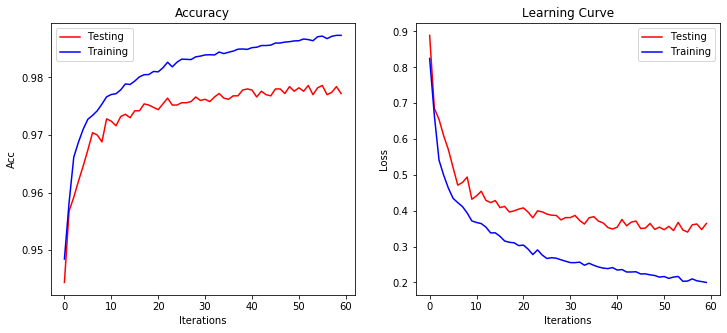

In [7]:
dropout_model = FNN(train_x,train_y,test_x,test_y,init_weights,init_biases,dropout=True)
dropout_model.train()

## 2.(b)
Dropout在訓練的時候，隨機將一些神經元關閉，這樣避免神經元之間過度依賴，但在Testing時將所有神經元開啟，訓練在小的資料集時使用dropout可以大幅降低overfitting的可能，比較1.(a)和2.(a)的結果比較可以發現經過dropout過後Accuracy些微上升且Loss降低了

## 3.(a) update input x while fixing w

In [88]:
import cv2
class updateX_FNN():
  def __init__(self,train_x,train_y,init_weights,init_biases):
    self.train_x = copy.deepcopy(train_x)
    self.train_y = copy.deepcopy(train_y)
    self.layer = [2048,512,5]
    self.learningRate = 0.0005
    self.weights = copy.deepcopy(init_weights)
    self.biases = copy.deepcopy(init_biases)

  def ReLU(self,X):
    return np.maximum(0,X)

  def softmax(self,X):
    X = X-np.max(X,axis=1,keepdims=True)
    X = np.exp(X)
    X = X/np.sum(X,axis=1,keepdims=True)
    return X

  def forward(self,X,weights,biases):
    z_data = []
    act_data = []
    w = copy.deepcopy(weights)
    b = copy.deepcopy(biases)

    z_data.append(np.dot(X, w[0])+b[0])
    act_data.append(self.ReLU(z_data[0]))  
  
    z_data.append(np.dot(act_data[0],w[1])+b[1])
    act_data.append(self.ReLU(z_data[1]))

    z_data.append(np.dot(act_data[1], w[2])+ b[2])
    act_data.append(self.softmax(z_data[2]))

    return z_data,act_data

  def backward_ReLU(self,X):
    # the derivate of ReLU
    X[X <= 0] = 0
    return X

  def backward_softmax(self,predict,true):
    dz = predict.copy()
    dz[range(len(predict)), true] -= 1
    return dz / len(predict)

  def backward(self,Z,A,w,b,x,y):
    dw_data = []
    db_data = []
    m = 256

    dz = self.backward_softmax(A[-1], y)
    dw_data.insert(0, 1/m * np.dot(A[1].T,dz))
    db_data.insert(0, 1/m * np.sum(dz,axis=0))

    dz = np.dot(dz,w[2].T) * self.backward_ReLU(A[1])
    dw_data.insert(0, 1/m * np.dot(A[0].T,dz))
    db_data.insert(0, 1/m * np.sum(dz,axis=0))

    dz = np.dot(dz,w[1].T) * self.backward_ReLU(A[0])
    dw_data.insert(0, 1/m * np.dot(x.T,dz))
    db_data.insert(0, 1/m * np.sum(dz,axis=0))

    dz = np.dot(dz,w[0].T) * 1/m
    for i in range(len(dz)):
      x[i] -= self.learningRate * dz[i]
    return x


  def cross_entropy(self,predict,target):
    target = np.eye(5)[target]
    return -np.sum(np.multiply(target , np.log(np.clip(predict,1e-7,1-1e-7))))/ len(target)

  def cal_accuracy(self,act_values,label):
    y_predict = np.argmax(act_values[-1],axis=1)
    return np.mean(y_predict==label)
  
  def train(self):
    weights = self.weights.copy()
    biases = self.biases.copy()
    train =  copy.deepcopy(self.train_x)
    label = copy.deepcopy(self.train_y)

    for i in range(5):
      # forward pass
      Z,A = self.forward(train,weights,biases) # A[-1] is prediction
      # backward pass and update
      train = self.backward(Z,A,weights,biases,train,label)
    
      train_z_data, train_act_values = self.forward(train,weights,biases)
      train_accu = self.cal_accuracy(train_act_values,label)
      train_loss = self.cross_entropy(train_act_values[-1],label)

      before_z_data, before_act_values = self.forward(self.train_x,weights,biases)
      before_accu = self.cal_accuracy(before_act_values,self.train_y)
      before_loss = self.cross_entropy(before_act_values[-1],self.train_y)
    
      print('Train Iteration: {}/{}【before update】 {} 【after update】 {} '.format(i+1,5,before_accu,train_accu))
      
    plt.figure()
    plt.imshow(np.reshape(train[0]*255,(28,28)),cmap='gray') 
    plt.show()

Train Iteration: 1/5【before update】 0.2109375 【after update】 0.51171875 
Train Iteration: 2/5【before update】 0.2109375 【after update】 0.71875 
Train Iteration: 3/5【before update】 0.2109375 【after update】 0.8828125 
Train Iteration: 4/5【before update】 0.2109375 【after update】 0.99609375 
Train Iteration: 5/5【before update】 0.2109375 【after update】 1.0 


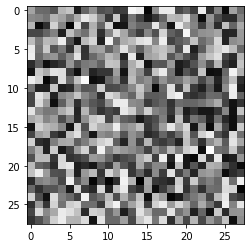

In [89]:
# generate a batch of (256) noise images
noise_train = np.random.randint(256, size=(256, 784))/255
# generate labels
img_label = np.random.randint(5, size=(256))
updateX = updateX_FNN(noise_train,img_label,model.finalWeights,model.finalBiases)
updateX.train()

## 3.(b) 
通過更新input資料讓model去學習如何產生正確的images，通過5次iterations就可以達到100%的accuracy，更新過後其中一張input images如上圖，可以看出實際上用肉眼看images就像雜訊一樣，但卻可以讓模型預測正確，是因為生成的images可以準確抓到會讓模型預測正確的特徵。